In [101]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from typing import Iterable, Any, Tuple, Dict


# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss


# Custom models
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import preprocess_data as ppd

In [102]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

# feature_names_base = ppd.load_feature_bases(weather_data_file, power_load_file)

all_data_df, _, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                        weather_data_path=weather_data_file,
                                                                                        power_load_data_path=power_load_file,
                                                                                        feature_names=['Temperature', 'Relative_humidity', 'Load', 'State'],
                                                                                        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                        state_one_hot=False,
                                                                                        initial_MC_state_filter='all',
                                                                                        technology_filter=['Gas Turbine/Jet Engine (Simple Cycle Operation)'],
                                                                                        test_periods=None
                                                                                        )

In [103]:
all_data_df

,State,Load,Temperature_3Dsum_cold,Temperature_3Dsum_hot,Datetime_UTC,Data_weight,Relative_humidity,Initial_gen_state,Final_gen_state,Temperature
0,5,-0.432571,18.893789,76.590370,2015-07-01 05:00:00+00:00,37.0,83.777939,0.0,0,20.704165
1,27,-0.442619,2.596057,123.195145,2015-07-01 05:00:00+00:00,1.0,88.425438,2.0,2,22.694269
2,29,-0.442619,31.450430,40.000961,2015-07-01 05:00:00+00:00,125.0,88.174149,0.0,0,18.918636
3,29,-0.442619,31.450430,40.000961,2015-07-01 05:00:00+00:00,1.0,88.174149,1.0,1,18.918636
4,29,-0.442619,31.450430,40.000961,2015-07-01 05:00:00+00:00,4.0,88.174149,2.0,2,18.918636
...,...,...,...,...,...,...,...,...,...,...
6944945,13,0.472338,417.500000,0.000000,2025-01-01 00:00:00+00:00,1.0,66.775864,2.0,2,0.608764
6944946,14,0.201790,263.232635,0.000000,2025-01-01 00:00:00+00:00,2.0,82.471634,1.0,1,5.778723
6944947,14,0.201790,263.232635,0.000000,2025-01-01 00:00:00+00:00,1.0,82.471634,2.0,2,5.778723
6944948,17,0.174725,267.953705,0.000000,2025-01-01 00:00:00+00:00,2.0,87.677780,2.0,2,9.714704


# A - AR order

### Create availability time series

In [104]:
def partial_avail(count):
    r = np.random.rand(int(count))
    r = 0.15 + r*0.85
    return np.sum(r)

In [105]:
time_series_per_state = {}

for state in all_data_df['State'].unique():
    state_df = all_data_df[all_data_df['State'] == state].copy()
    state_df = state_df.groupby(['Datetime_UTC', 'Final_gen_state'])['Data_weight'].sum()
    state_df = state_df.unstack(level=-1).fillna(0)
    state_df = state_df.sort_index()
    if 1 not in state_df.columns:
        state_df[1] = 0
    state_df['n_generators'] = state_df[0] + state_df[1] + state_df[2]
    state_df['Total'] = state_df[0] + state_df[1].apply(partial_avail)
    state_df['Total'] = state_df['Total'] / state_df['n_generators']
    time_series_per_state[state] = state_df['Total'].values
    


### Compute AR order with partial autocorrelation function

In [106]:
from statsmodels.tsa.stattools import pacf
import numpy as np
import matplotlib.pyplot as plt

In [107]:
def compute_pacf_per_state(time_series_per_state, max_lag=48):
    pacfs = {}
    for state, y in time_series_per_state.items():
        y = np.asarray(y, dtype=float)
        y = y[np.isfinite(y)]
        if len(y) < max_lag + 10:
            continue
        pacfs[state] = pacf(y, nlags=max_lag, method="ywm")
    return pacfs

In [108]:
def plot_average_pacf(time_series_per_state, max_lag=48, figsize=(10,5)):
    pacfs = compute_pacf_per_state(time_series_per_state, max_lag)

    # Stack into matrix (n_states, max_lag+1)
    pacf_mat = np.vstack(list(pacfs.values()))
    
    mean_pacf = pacf_mat.mean(axis=0)
    std_pacf  = pacf_mat.std(axis=0)
    
    n_states = pacf_mat.shape[0]
    # conf = 1.96 / (np.sqrt(n_states))   # approximate CI for mean
    conf = 1.96/np.sqrt(np.sum([len(y) for y in time_series_per_state.values()]))  # approximate CI for mean over all data points
    
    lags = np.arange(len(mean_pacf))

    plt.figure(figsize=figsize)
    plt.stem(lags, mean_pacf, basefmt=" ", linefmt="C0-", markerfmt="C0o")

    plt.axhline(0, color="black", linewidth=1)
    plt.xlabel("Lag (hours)")
    plt.ylabel("Partial autocorrelation")
    plt.title("Average PACF of generator availability across states")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

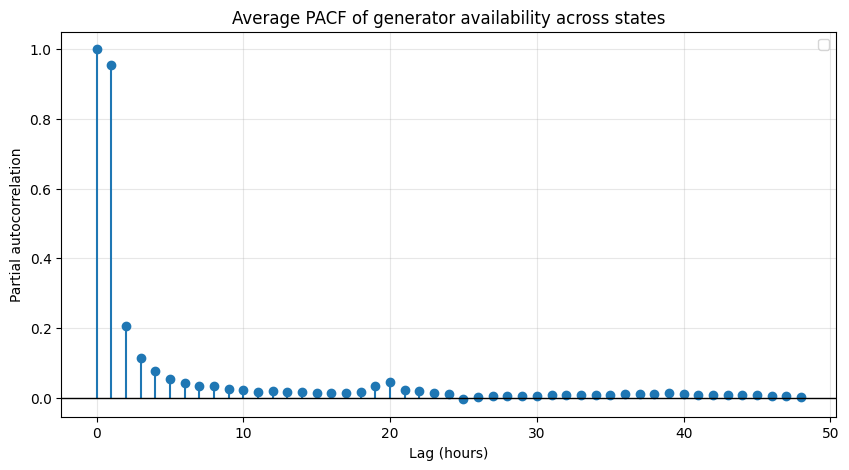

In [109]:
plot_average_pacf(time_series_per_state, max_lag=48)

In [112]:
def plot_average_pacf_paper(
    time_series_per_state,
    max_lag=48,
    figsize=(7.0, 3.2),
    drop_lag0=True,
    ci_method="bootstrap",   # "bootstrap" or "se"
    n_boot=2000,
    seed=0,
    title="Average PACF of generator availability across states",
):
    pacfs = compute_pacf_per_state(time_series_per_state, max_lag)
    states = list(pacfs.keys())
    pacf_mat = np.vstack([pacfs[s] for s in states])  # shape (n_states, max_lag+1)

    mean_pacf = pacf_mat.mean(axis=0)

    # --- Uncertainty band for the mean across states ---
    if ci_method == "bootstrap":
        rng = np.random.default_rng(seed)
        idx = np.arange(pacf_mat.shape[0])
        boot_means = np.empty((n_boot, pacf_mat.shape[1]), dtype=float)
        for b in range(n_boot):
            samp = rng.choice(idx, size=len(idx), replace=True)
            boot_means[b] = pacf_mat[samp].mean(axis=0)
        lo = np.quantile(boot_means, 0.025, axis=0)
        hi = np.quantile(boot_means, 0.975, axis=0)
        band_label = "95% bootstrap CI"
    elif ci_method == "se":
        se = pacf_mat.std(axis=0, ddof=1) / np.sqrt(pacf_mat.shape[0])
        lo = mean_pacf - 1.96 * se
        hi = mean_pacf + 1.96 * se
        band_label = "95% CI (normal approx.)"
    else:
        raise ValueError("ci_method must be 'bootstrap' or 'se'")

    lags = np.arange(pacf_mat.shape[1])

    if drop_lag0:
        lags = lags[1:]
        mean_pacf = mean_pacf[1:]
        lo = lo[1:]
        hi = hi[1:]

    fig, ax = plt.subplots(figsize=figsize)

    # Subtle grid + clean spines
    ax.grid(True, axis="y", alpha=0.25, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # CI band
    ax.fill_between(lags, lo, hi, alpha=0.18, linewidth=0, label=band_label)

    # Mean PACF as lollipops (stem-like, but with nicer control)
    ax.vlines(lags, 0, mean_pacf, linewidth=1.4, alpha=0.9)
    ax.scatter(lags, mean_pacf, s=28, alpha=0.95, label="Mean PACF")

    # Zero line
    ax.axhline(0, linewidth=1.0, color="black", alpha=0.8)

    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Partial autocorrelation")
    ax.set_title(title)

    # Ticks: fewer, cleaner
    ax.set_xlim(lags.min() - 0.5, lags.max() + 0.5)
    ax.set_xticks(np.arange(0 if not drop_lag0 else 1, max_lag + 1, 6))
    ax.tick_params(axis="both", labelsize=10)

    # Legend (only because we have meaningful labels now)
    ax.legend(frameon=False, loc="upper right")

    fig.tight_layout()
    plt.show()

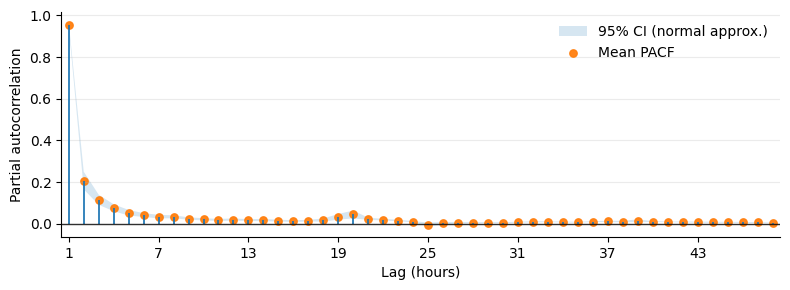

In [116]:
plot_average_pacf_paper(time_series_per_state, max_lag=48, figsize=(8,3), ci_method="se", title='')

# B - Transition pairs that matter

In [96]:
trans_count = all_data_df.groupby(['Initial_gen_state', 'Final_gen_state'])['Data_weight'].sum().unstack()
L = len(all_data_df.drop_duplicates(subset=['Datetime_UTC']))

L/trans_count

Final_gen_state,0,1,2
Initial_gen_state,,,
0.0,0.000606,9.698871,1.160180
1.0,9.435285,0.020816,94.900909
2.0,1.165862,75.886154,0.015936


In [97]:
trans_count

Final_gen_state,0,1,2
Initial_gen_state,,,
0.0,137600640.0,8591.0,71819.0
1.0,8831.0,4002773.0,878.0
2.0,71469.0,1098.0,5228567.0


**CONCLUSION** 

Abandon U->O and O->U

In [98]:
all_data_df.loc[(all_data_df['Initial_gen_state']==1)&(all_data_df['Final_gen_state']==2), 'Final_gen_state'] = 1
all_data_df.loc[(all_data_df['Initial_gen_state']==2)&(all_data_df['Final_gen_state']==1), 'Final_gen_state'] = 2

# Evidence of dependence on features

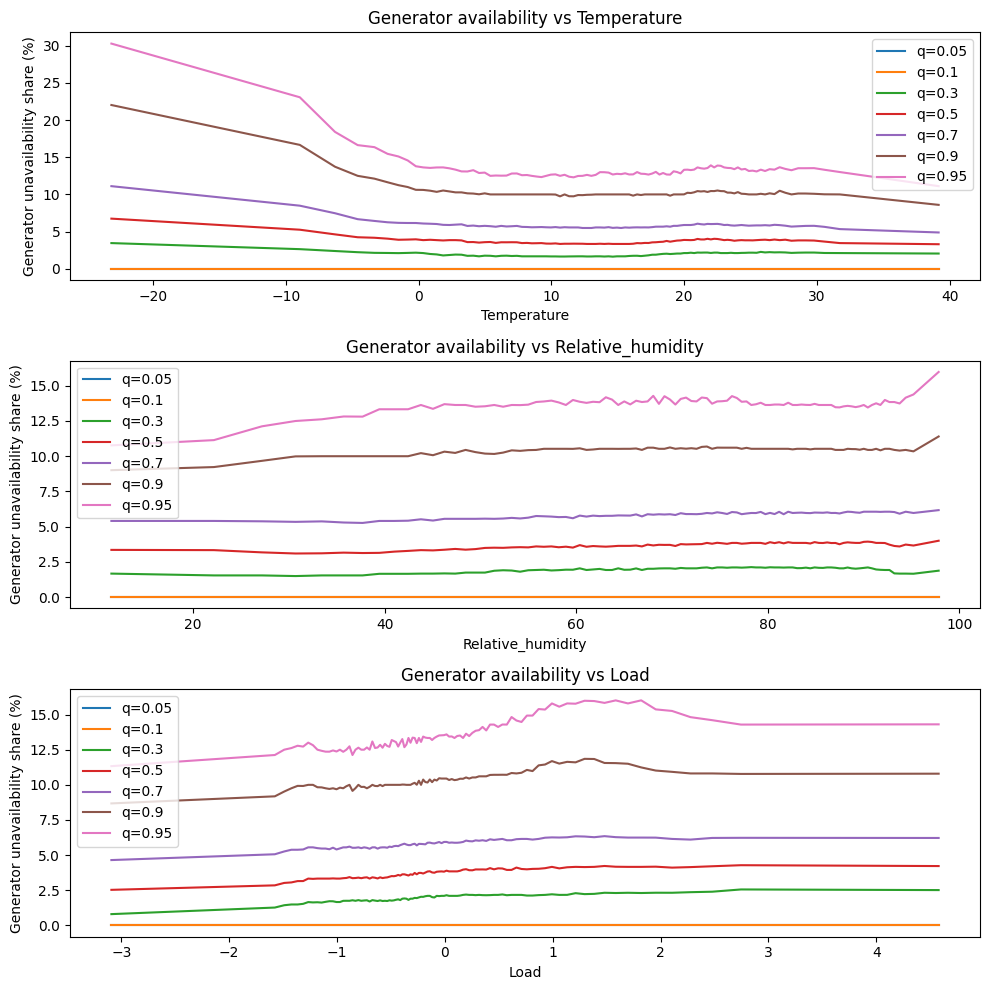

In [99]:
features = ['Temperature', 'Relative_humidity', 'Load']
q_plot = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
n_bins = 100

fig, ax = plt.subplots(len(features), figsize=(10,10))

for i, feature in enumerate(features):
    F = []
    W = []
    V = []
    for state, state_scenario in time_series_per_state.items():
        df_state = all_data_df[all_data_df['State'] == state].groupby(['Datetime_UTC', feature])['Data_weight'].sum().reset_index()
        assert len(df_state) == len(state_scenario), "Length mismatch"
        f = df_state[feature].values
        w = df_state['Data_weight'].values
        F.extend(f)
        W.extend(w)
        V.extend(1-state_scenario)
    F = np.array(F)
    W = np.array(W)
    V = np.array(V)

    bin_edges = np.quantile(F, q=np.linspace(0,1,n_bins+1), method='inverted_cdf', weights=W)

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    bin_quantiles = {}
    for q in q_plot:
        bin_q = []
        for j in range(n_bins):
            mask = (F >= bin_edges[j]) & (F < bin_edges[j+1])
            if np.sum(mask) == 0:
                bin_q.append(np.nan)
            else:
                bin_q.append(np.quantile(V[mask], q=q, method='inverted_cdf', weights=W[mask]))
        bin_quantiles[q] = np.array(bin_q)
    for q in q_plot:
        ax[i].plot(bin_centers, bin_quantiles[q]*100, label=f"q={q}")
    ax[i].legend()
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel("Generator unavailability share (%)")
    ax[i].set_title(f"Generator availability vs {feature}")

plt.tight_layout()


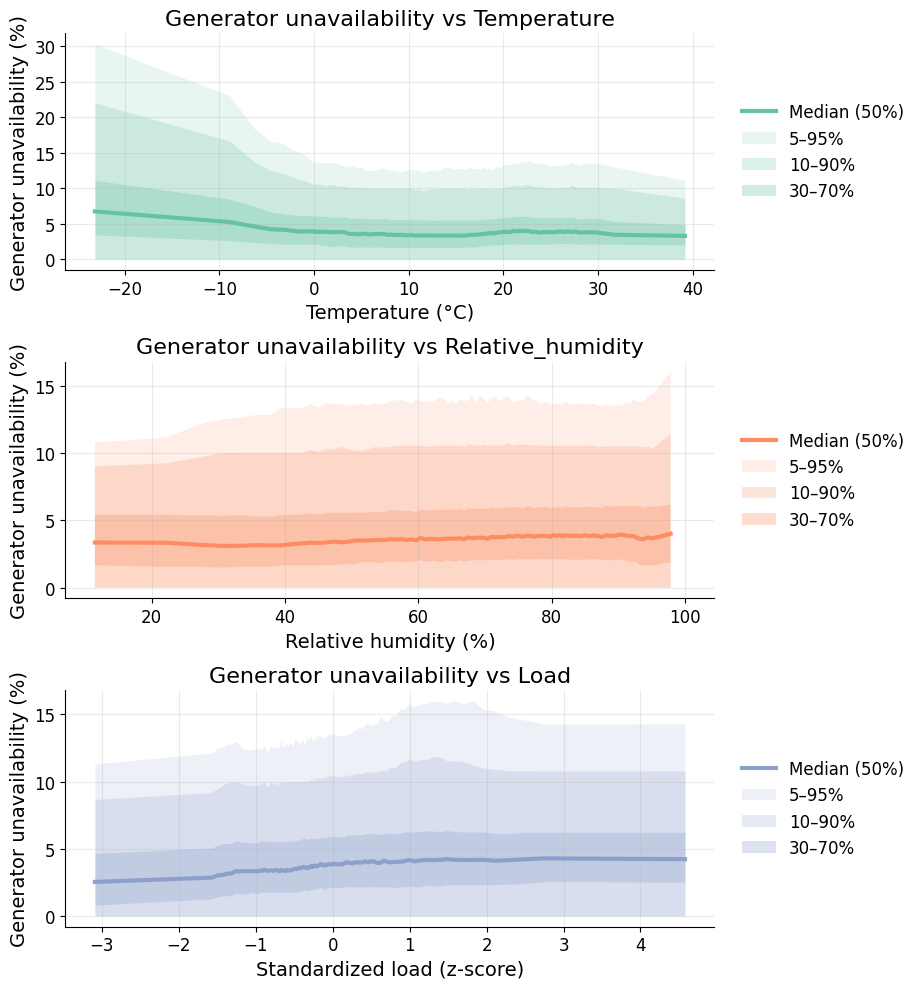

In [100]:
# ---------- helpers ----------
def weighted_quantile(x, q, w=None):
    x = np.asarray(x, dtype=float)
    q = np.asarray(q, dtype=float)

    if w is None:
        return np.quantile(x, q)

    w = np.asarray(w, dtype=float)
    mask = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x = x[mask]
    w = w[mask]
    if len(x) == 0:
        return np.nan if q.ndim == 0 else np.full_like(q, np.nan, dtype=float)

    idx = np.argsort(x)
    x_sorted = x[idx]
    w_sorted = w[idx]
    cw = np.cumsum(w_sorted)
    cw = cw / cw[-1]

    return np.interp(q, cw, x_sorted)


def style_axis(ax, ticksize=12):
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=ticksize)


# ---------- plot ----------
features = ["Temperature", "Relative_humidity", "Load"]
feature_labels = {
    "Temperature": "Temperature (°C)",
    "Relative_humidity": "Relative humidity (%)",
    "Load": "Standardized load (z-score)"
}

n_bins = 100

# Inter-quantile bands (nested)
bands = [
    (0.05, 0.95, 0.15),
    (0.10, 0.90, 0.22),
    (0.30, 0.70, 0.30),
]
q_median = 0.50

fig, axs = plt.subplots(len(features), 1, figsize=(11, 10), sharex=False)
if len(features) == 1:
    axs = [axs]

cmap = plt.cm.Set2  # one nice color per subplot

for i, feature in enumerate(features):
    ax = axs[i]
    color = cmap(i % cmap.N)

    # ---- pool all states into (F, V, W) ----
    F, V, W = [], [], []
    for state, state_scenario in time_series_per_state.items():
        df_state = (
            all_data_df[all_data_df["State"] == state]
            .groupby("Datetime_UTC")[["Data_weight", feature]]
            .agg({"Data_weight": "sum", feature: "mean"})
            .reset_index()
            .sort_values("Datetime_UTC")
        )

        assert len(df_state) == len(state_scenario), "Length mismatch"

        f = df_state[feature].to_numpy()
        w = df_state["Data_weight"].to_numpy()
        v = 1.0 - np.asarray(state_scenario, dtype=float)

        F.append(f); W.append(w); V.append(v)

    F = np.concatenate(F)
    W = np.concatenate(W)
    V = np.concatenate(V)

    # ---- equal-mass bins in F ----
    qs = np.linspace(0, 1, n_bins + 1)
    bin_edges = weighted_quantile(F, qs, w=W)
    bin_edges[-1] = np.nextafter(bin_edges[-1], np.inf)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # ---- per-bin quantiles of V ----
    def bin_stat(q):
        out = np.full(n_bins, np.nan)
        for j in range(n_bins):
            m = (F >= bin_edges[j]) & (F < bin_edges[j+1])
            if np.any(m):
                out[j] = weighted_quantile(V[m], q, w=W[m])
        return out

    med = bin_stat(q_median)

    # shaded bands
    for qlo, qhi, alpha in bands:
        lo = bin_stat(qlo)
        hi = bin_stat(qhi)
        ax.fill_between(
            bin_centers,
            100 * lo,
            100 * hi,
            color=color,
            alpha=alpha,
            linewidth=0,
            label=f"{int(qlo*100)}–{int(qhi*100)}%"
        )

    # median line
    ax.plot(
        bin_centers,
        100 * med,
        color=color,
        linewidth=3.0,
        label="Median (50%)"
    )

    # ---- formatting ----
    ax.set_xlabel(feature_labels[feature], fontsize=14)
    ax.set_ylabel("Generator unavailability (%)", fontsize=14)
    ax.set_title(f"Generator unavailability vs {feature}", fontsize=16)
    style_axis(ax)

    # Legend outside on the right
    handles, labels = ax.get_legend_handles_labels()
    idx_med = labels.index("Median (50%)")
    order = [idx_med] + [k for k in range(len(labels)) if k != idx_med]

    ax.legend(
        [handles[k] for k in order],
        [labels[k] for k in order],
        frameon=False,
        fontsize=12,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)   # outside right
    )

plt.tight_layout(rect=(0, 0, 0.85, 1))  # leave space on right for legends
plt.show()